# Plotting TRIOS Complex Modulus Data

**Comprehensive Reference Guide** for plotting complex modulus data loaded from TRIOS files without matplotlib warnings.

This notebook demonstrates:
- ✅ **4 correct approaches** for plotting complex modulus data
- ⚠️ **Data quality checks** for experimental artifacts
- 🛠️ **Handling negative G''** values from noise

## The Problem

TRIOS frequency sweep data contains both Storage (G') and Loss (G'') moduli. RheoJAX correctly loads this as complex modulus:
```python
G* = G' + i·G''
```

However, matplotlib **cannot plot complex-valued arrays directly**. This causes warnings:
- `ComplexWarning: Casting complex values to real discards the imaginary part`
- `UserWarning: Data has no positive values, and therefore cannot be log-scaled`

## Solutions

We provide **four correct approaches** below, from easiest to most flexible.

In [ ]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

In [1]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from rheojax.io import load_trios

# Load TRIOS data (returns complex modulus)
data_list = load_trios('../data/experimental/frequency_sweep_tts.txt')
print(f"Loaded {len(data_list)} temperature segments")
print(f"Data type: {data_list[0].y.dtype}")
print(f"Is complex: {np.iscomplexobj(data_list[0].y)}")

INFO:2025-11-14 08:21:31,463:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Loading rheojax version 0.2.0
/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Loaded 20 temperature segments
Data type: complex128
Is complex: True


## ❌ WRONG: Direct Plotting (Causes Warnings)

**DO NOT DO THIS:**

In [2]:
# ❌ WRONG - This will trigger ComplexWarning
# plt.loglog(data_list[0].x, data_list[0].y)
# plt.tight_layout()  # <-- Warnings appear here

print("⚠️  Commented out to prevent warnings. This is the INCORRECT approach.")

⚠️  Commented out to prevent warnings. This is the INCORRECT approach.


## ✅ Solution 1: Use RheoJAX Visualization (Recommended)

The easiest and most reliable approach is to use RheoJAX's built-in plotting functions that automatically handle complex modulus data.

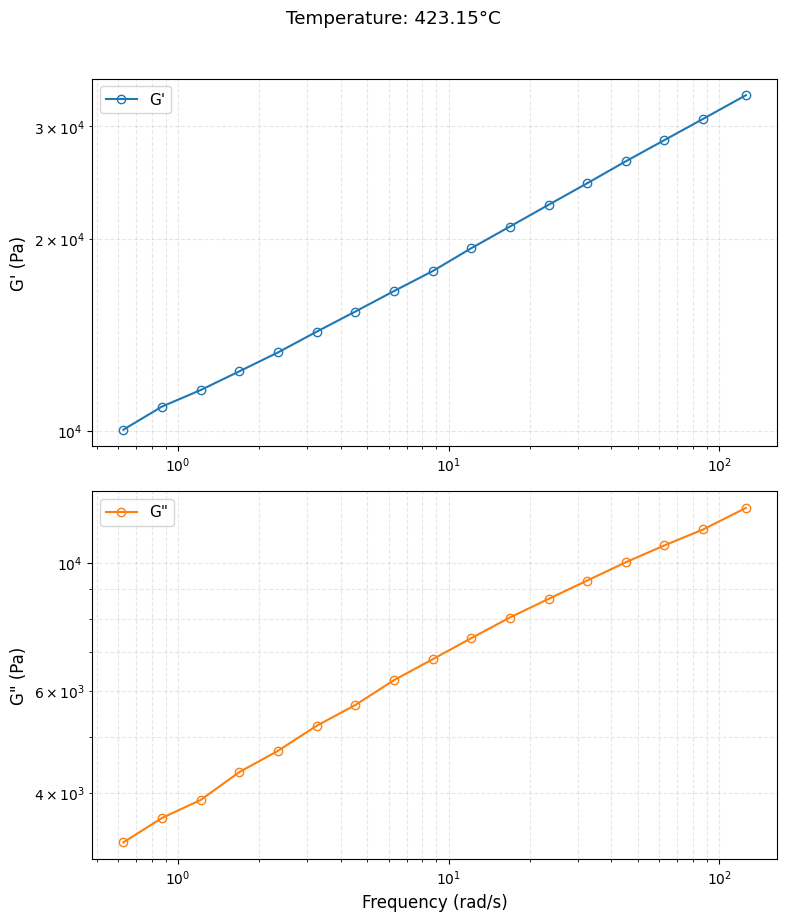

✓ No warnings! G' and G'' plotted in separate subplots.


In [3]:
from rheojax.visualization import plot_rheo_data

# ✅ CORRECT - Automatic complex modulus handling
fig, axes = plot_rheo_data(data_list[0])
plt.suptitle(f"Temperature: {data_list[0].metadata.get('temperature', 'N/A')}°C", y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

print("✓ No warnings! G' and G'' plotted in separate subplots.")

## ✅ Solution 2: Manual Component Extraction

If you need custom matplotlib control, manually extract the real and imaginary components.

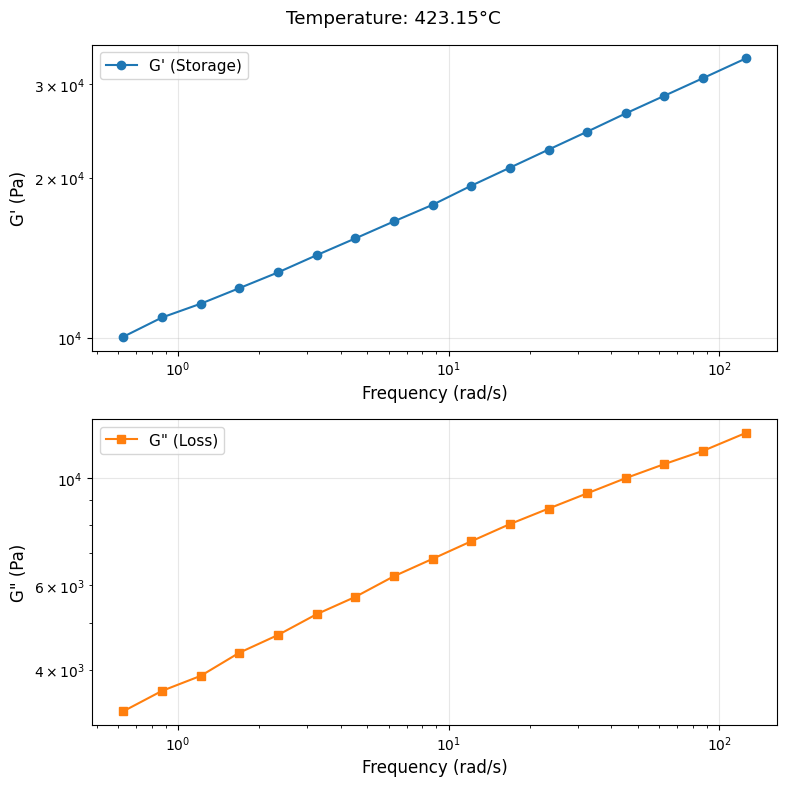

✓ No warnings! Components extracted before plotting.


In [4]:
# ✅ CORRECT - Manual extraction of G' and G''
data = data_list[0]

# Extract components from complex modulus
omega = data.x  # Frequency (rad/s)
G_prime = np.real(data.y)  # Storage modulus (G')
G_double_prime = np.imag(data.y)  # Loss modulus (G'')

# Plot on separate axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# G' (Storage modulus)
ax1.loglog(omega, G_prime, 'o-', label="G' (Storage)", color='C0')
ax1.set_xlabel('Frequency (rad/s)')
ax1.set_ylabel("G' (Pa)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# G'' (Loss modulus)
ax2.loglog(omega, G_double_prime, 's-', label='G" (Loss)', color='C1')
ax2.set_xlabel('Frequency (rad/s)')
ax2.set_ylabel('G" (Pa)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle(f"Temperature: {data.metadata.get('temperature', 'N/A')}°C")
plt.tight_layout()
display(fig)
plt.close(fig)

print("✓ No warnings! Components extracted before plotting.")

## ✅ Solution 3: Plot G' and G'' on Same Axes

For comparison, plot both components on a single log-log plot.

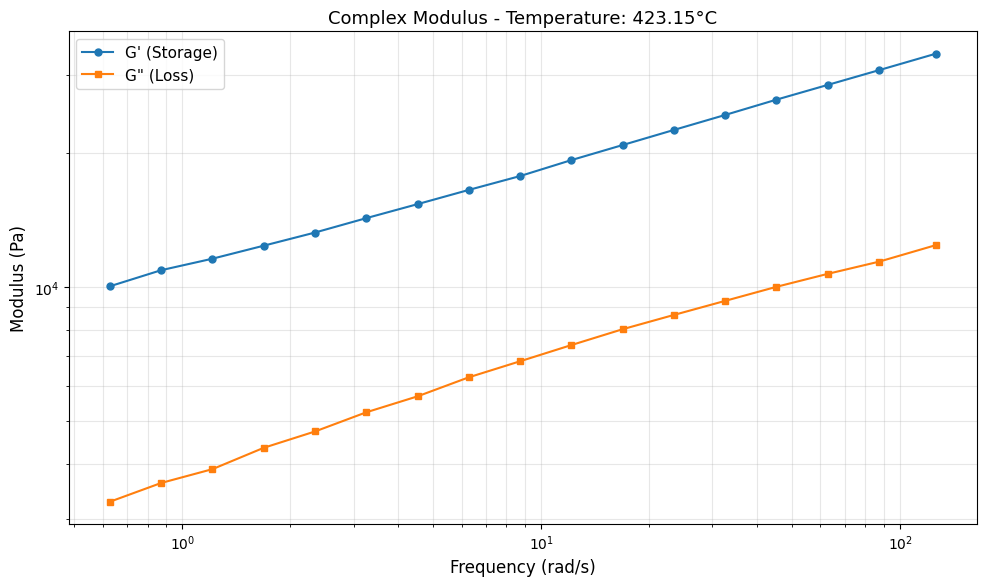

✓ No warnings! Both components on same axes.


In [5]:
# ✅ CORRECT - Both components on same axes
data = data_list[0]
omega = data.x
G_prime = np.real(data.y)
G_double_prime = np.imag(data.y)

fig, ax = plt.subplots(figsize=(10, 6))

ax.loglog(omega, G_prime, 'o-', label="G' (Storage)", color='C0', markersize=5)
ax.loglog(omega, G_double_prime, 's-', label='G" (Loss)', color='C1', markersize=5)

ax.set_xlabel('Frequency (rad/s)', fontsize=12)
ax.set_ylabel('Modulus (Pa)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both')
ax.set_title(f"Complex Modulus - Temperature: {data.metadata.get('temperature', 'N/A')}°C", fontsize=13)

plt.tight_layout()
display(fig)
plt.close(fig)

print("✓ No warnings! Both components on same axes.")

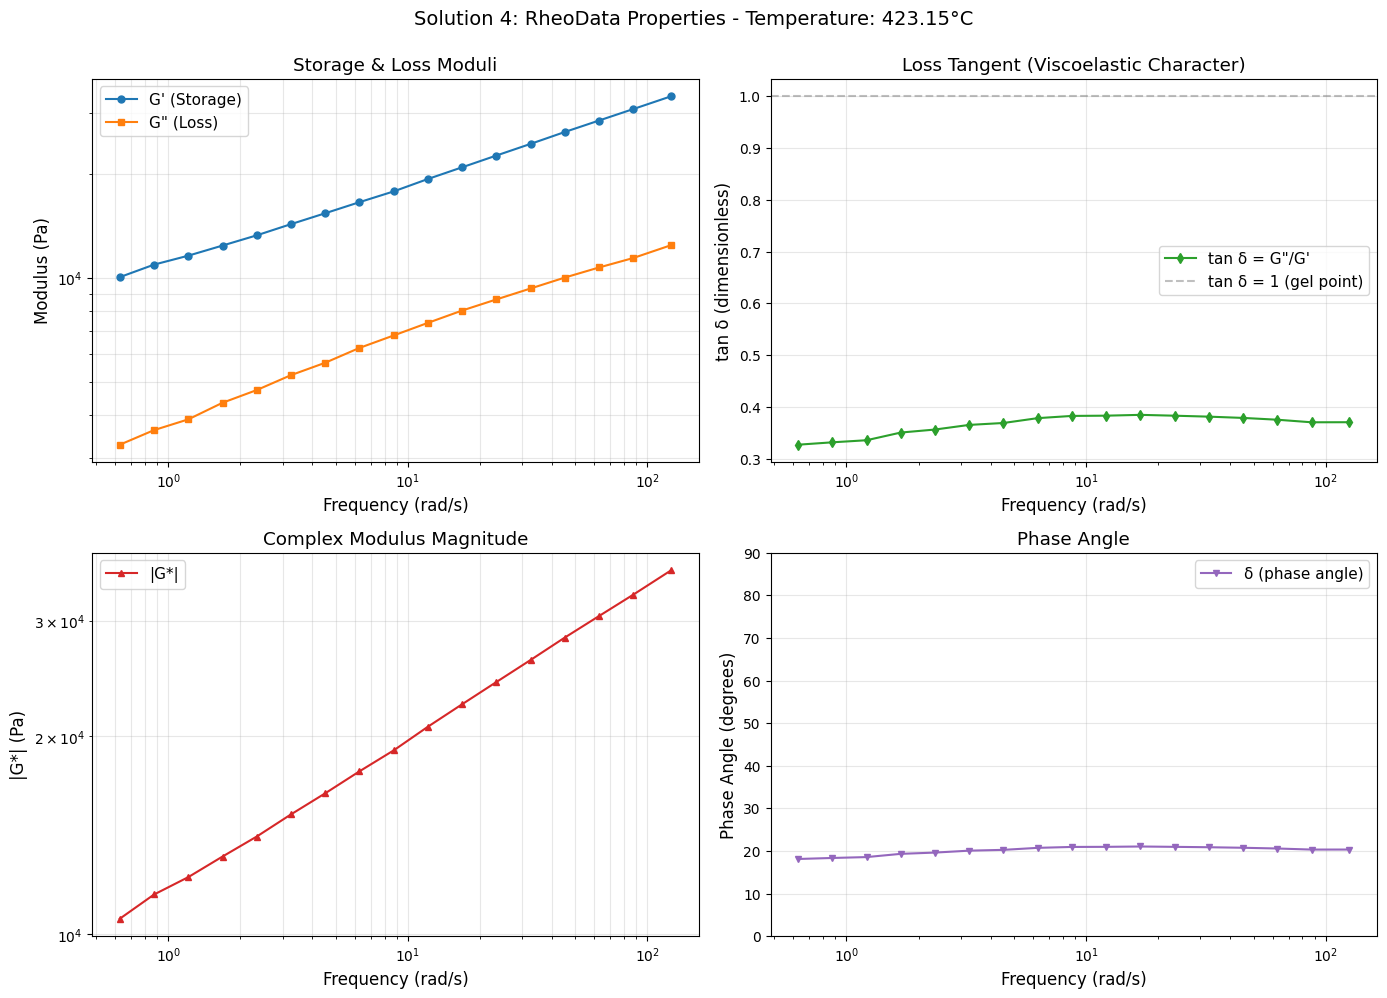

✓ No warnings! Using RheoData convenience properties.

Available properties for complex modulus data:
  • data.y_real / data.storage_modulus  → G'
  • data.y_imag / data.loss_modulus     → G''
  • data.tan_delta                       → tan δ = G''/G'
  • data.modulus                         → |G*|
  • data.phase                           → Phase angle (radians)

Note: Use np.degrees(data.phase) to convert phase to degrees


In [6]:
# ✅ CORRECT - Using RheoData convenience properties
data = data_list[0]

# Access components via properties (cleaner than np.real/np.imag)
omega = data.x
G_prime = data.y_real              # Equivalent to data.storage_modulus
G_double_prime = data.y_imag       # Equivalent to data.loss_modulus
tan_delta = data.tan_delta         # G''/G' ratio
modulus_magnitude = data.modulus   # |G*| magnitude
phase_angle = np.degrees(data.phase)  # Phase angle (convert radians to degrees)

# Create comprehensive plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# G' and G'' on same plot
ax1.loglog(omega, G_prime, 'o-', label="G' (Storage)", color='C0', markersize=5)
ax1.loglog(omega, G_double_prime, 's-', label='G" (Loss)', color='C1', markersize=5)
ax1.set_xlabel('Frequency (rad/s)')
ax1.set_ylabel('Modulus (Pa)')
ax1.set_title("Storage & Loss Moduli")
ax1.legend()
ax1.grid(True, alpha=0.3, which='both')

# Loss tangent (viscoelastic character)
ax2.semilogx(omega, tan_delta, 'd-', color='C2', markersize=5, label='tan δ = G"/G\'')
ax2.axhline(1.0, color='gray', linestyle='--', alpha=0.5, label='tan δ = 1 (gel point)')
ax2.set_xlabel('Frequency (rad/s)')
ax2.set_ylabel('tan δ (dimensionless)')
ax2.set_title('Loss Tangent (Viscoelastic Character)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Complex modulus magnitude
ax3.loglog(omega, modulus_magnitude, '^-', color='C3', markersize=5, label='|G*|')
ax3.set_xlabel('Frequency (rad/s)')
ax3.set_ylabel('|G*| (Pa)')
ax3.set_title('Complex Modulus Magnitude')
ax3.legend()
ax3.grid(True, alpha=0.3, which='both')

# Phase angle
ax4.semilogx(omega, phase_angle, 'v-', color='C4', markersize=5, label='δ (phase angle)')
ax4.set_xlabel('Frequency (rad/s)')
ax4.set_ylabel('Phase Angle (degrees)')
ax4.set_title('Phase Angle')
ax4.set_ylim([0, 90])
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle(f"Solution 4: RheoData Properties - Temperature: {data.metadata.get('temperature', 'N/A')}°C", 
             fontsize=14, y=0.995)
plt.tight_layout()
display(fig)
plt.close(fig)

print("✓ No warnings! Using RheoData convenience properties.")
print("\nAvailable properties for complex modulus data:")
print("  • data.y_real / data.storage_modulus  → G'")
print("  • data.y_imag / data.loss_modulus     → G''")
print("  • data.tan_delta                       → tan δ = G''/G'")
print("  • data.modulus                         → |G*|")
print("  • data.phase                           → Phase angle (radians)")
print("\nNote: Use np.degrees(data.phase) to convert phase to degrees")

## ✅ Solution 4: Use RheoData Convenience Properties (NEW in v0.2.0)

RheoData provides convenient properties for accessing complex modulus components and derived quantities without manual extraction. This is the **cleanest API** and recommended for production code.

## Plot All Temperature Segments

Demonstrate plotting multiple temperature segments correctly.

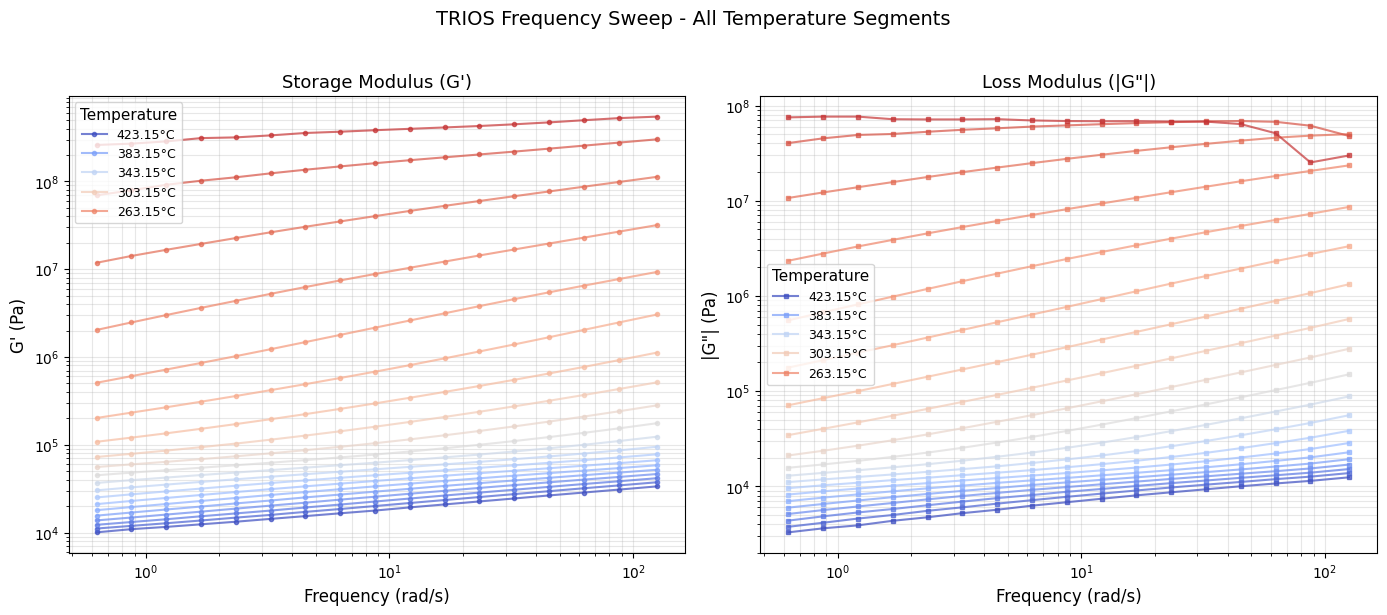

✓ Successfully plotted 20 temperature segments!
  Note: Using |G''| (absolute value) to handle 1 negative data point in segment 19.


In [7]:
# ✅ CORRECT - Plot all 20 temperature segments
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Use a colormap for temperature gradient
cmap = plt.cm.coolwarm
n_segments = len(data_list)

for i, data in enumerate(data_list):
    omega = data.x
    G_prime = np.real(data.y)
    G_double_prime = np.imag(data.y)
    
    temp = data.metadata.get('temperature', 0)
    color = cmap(i / n_segments)
    
    # Plot G'
    ax1.loglog(omega, G_prime, 'o-', color=color, alpha=0.7, markersize=3,
               label=f"{temp}°C" if i % 4 == 0 else None)  # Label every 4th for clarity
    
    # Plot G'' (use absolute value to avoid log-scale issues with negative values)
    ax2.loglog(omega, np.abs(G_double_prime), 's-', color=color, alpha=0.7, markersize=3,
               label=f"{temp}°C" if i % 4 == 0 else None)

ax1.set_xlabel('Frequency (rad/s)', fontsize=12)
ax1.set_ylabel("G' (Pa)", fontsize=12)
ax1.set_title("Storage Modulus (G')", fontsize=13)
ax1.legend(title='Temperature', fontsize=9)
ax1.grid(True, alpha=0.3, which='both')

ax2.set_xlabel('Frequency (rad/s)', fontsize=12)
ax2.set_ylabel('|G"| (Pa)', fontsize=12)
ax2.set_title('Loss Modulus (|G"|)', fontsize=13)
ax2.legend(title='Temperature', fontsize=9)
ax2.grid(True, alpha=0.3, which='both')

plt.suptitle('TRIOS Frequency Sweep - All Temperature Segments', fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"✓ Successfully plotted {n_segments} temperature segments!")
print("  Note: Using |G''| (absolute value) to handle 1 negative data point in segment 19.")

## Data Quality Check

Real experimental data may contain artifacts such as:
- **Negative G''** values (physically impossible for linear viscoelastic materials)
- **Outliers** from instrument noise or calibration issues
- **Missing data** points

For log-scale plotting, negative values cause warnings. Solutions:
1. Use `np.abs()` to take absolute value
2. Filter out negative values before plotting
3. Investigate and potentially exclude problematic segments

In [8]:
# Check data quality across all segments
all_G_prime = np.concatenate([np.real(d.y) for d in data_list])
all_G_double_prime = np.concatenate([np.imag(d.y) for d in data_list])

print("Data Quality Report:")
print("=" * 50)
print(f"G' (Storage Modulus):")
print(f"  Range: {all_G_prime.min():.1f} - {all_G_prime.max():.1f} Pa")
print(f"  All positive: {np.all(all_G_prime > 0)}")
print(f"\nG'' (Loss Modulus):")
print(f"  Range: {all_G_double_prime.min():.1f} - {all_G_double_prime.max():.1f} Pa")
print(f"  All positive: {np.all(all_G_double_prime > 0)}")

if not np.all(all_G_double_prime > 0):
    n_negative = np.sum(all_G_double_prime < 0)
    total = len(all_G_double_prime)
    print(f"  Negative values: {n_negative}/{total} ({100*n_negative/total:.1f}%)")
    
    # Find which segment has negative values
    for i, data in enumerate(data_list):
        G_dp = np.imag(data.y)
        if np.any(G_dp < 0):
            temp = data.metadata.get('temperature', 'N/A')
            print(f"  ⚠️  Segment {i} (T={temp}K / {temp-273.15:.1f}°C): {np.sum(G_dp<0)} negative value(s)")

print(f"\nLoss Tangent (tan δ = G''/G'):")
# Use absolute value for tan delta calculation to avoid issues
tan_delta = np.abs(all_G_double_prime) / all_G_prime
print(f"  Range: {tan_delta.min():.3f} - {tan_delta.max():.3f}")
print(f"  Material type: {'Elastic-dominant' if tan_delta.mean() < 1 else 'Viscous-dominant'}")
print("=" * 50)

print("\n✓ Data loaded successfully!")
print("  Recommendation: Use np.abs(G'') for log-scale plotting or filter negative values.")
print(f"  G' is always positive ({np.all(all_G_prime > 0)}).")
print(f"  G'' has {n_negative if not np.all(all_G_double_prime > 0) else 0} negative value(s) - likely experimental noise.")

Data Quality Report:
G' (Storage Modulus):
  Range: 10044.3 - 546905280.0 Pa
  All positive: True

G'' (Loss Modulus):
  Range: -29868376.0 - 76454416.0 Pa
  All positive: False
  Negative values: 1/340 (0.3%)
  ⚠️  Segment 19 (T=233.14999999999998K / -40.0°C): 1 negative value(s)

Loss Tangent (tan δ = G''/G'):
  Range: 0.048 - 1.181
  Material type: Elastic-dominant

✓ Data loaded successfully!
  Recommendation: Use np.abs(G'') for log-scale plotting or filter negative values.
  G' is always positive (True).
  G'' has 1 negative value(s) - likely experimental noise.


## Summary

### Key Takeaways

1. **TRIOS data is complex-valued**: `G* = G' + i·G''`
2. **Matplotlib cannot plot complex arrays**: Must extract real/imaginary parts first
3. **Four correct approaches for plotting**:
   - **Solution 1**: Use `plot_rheo_data()` (easiest, recommended for quick visualization)
   - **Solution 2**: Manual extraction with `np.real()` and `np.imag()` (flexible, full control)
   - **Solution 3**: Plot both on same axes (good for comparison)
   - **Solution 4**: Use RheoData properties (cleanest API, includes tan δ, |G*|, phase)

### Handling Data Quality Issues

**Negative G'' values** (physically impossible but can occur from experimental noise):
- **Option 1**: Use `np.abs(G'')` to take absolute value (preserves all data)
- **Option 2**: Filter negative values with boolean masking (removes bad points)

In this dataset: 1 negative G'' value in segment 19 at -40°C (0.3% of 340 total points)

### What NOT to Do

```python
# ❌ WRONG - Triggers ComplexWarning
plt.loglog(data.x, data.y)
```

### What TO Do

```python
# ✅ Solution 1: RheoJAX visualization (easiest)
from rheojax.visualization import plot_rheo_data
plot_rheo_data(data)

# ✅ Solution 2: Manual extraction
plt.loglog(data.x, np.real(data.y), label="G'")
plt.loglog(data.x, np.abs(np.imag(data.y)), label='|G"|')  # Use abs() if negative values exist

# ✅ Solution 3: Filter negative values
G_dp = np.imag(data.y)
mask = G_dp > 0
plt.loglog(data.x[mask], G_dp[mask], label='G"')

# ✅ Solution 4: RheoData properties (recommended for production code)
plt.loglog(data.x, data.y_real, label="G'")              # or data.storage_modulus
plt.loglog(data.x, data.y_imag, label='G"')              # or data.loss_modulus
plt.semilogx(data.x, data.tan_delta, label='tan δ')      # G''/G' ratio
plt.semilogx(data.x, np.degrees(data.phase), label='δ')  # Phase (convert to degrees)
```

### RheoData Convenience Properties

For complex modulus data, RheoData provides these properties:
- `data.y_real` / `data.storage_modulus` → G' (Storage modulus)
- `data.y_imag` / `data.loss_modulus` → G'' (Loss modulus)
- `data.tan_delta` → tan δ = G''/G' (Viscoelastic character)
- `data.modulus` → |G*| (Complex modulus magnitude)
- `data.phase` → Phase angle (**radians**; use `np.degrees()` for degrees)

### Best Practices

- Always check data quality before plotting (`np.all(G'' > 0)`)
- Use absolute value or filtering for log-scale plots with negative values
- Investigate source of negative values (instrument noise, calibration, low temperature)
- Document any data filtering in analysis notes
- For production code, prefer Solution 4 (RheoData properties) for cleaner API
- For quick exploration, use Solution 1 (`plot_rheo_data()`)

---

**Note**: This notebook replaces the previous `fix_trios_plotting_warnings.py` script, consolidating all approaches into one comprehensive reference.

## Summary

### Key Takeaways

1. **TRIOS data is complex-valued**: `G* = G' + i·G''`
2. **Matplotlib cannot plot complex arrays**: Must extract real/imaginary parts first
3. **Four correct approaches for plotting**:
   - **Solution 1**: Use `plot_rheo_data()` (easiest, recommended for quick visualization)
   - **Solution 2**: Manual extraction with `np.real()` and `np.imag()` (flexible, full control)
   - **Solution 3**: Plot both on same axes (good for comparison)
   - **Solution 4**: Use RheoData properties (cleanest API, includes tan δ, |G*|, phase)

### Handling Data Quality Issues

**Negative G'' values** (physically impossible but can occur from experimental noise):
- **Option 1**: Use `np.abs(G'')` to take absolute value (preserves all data)
- **Option 2**: Filter negative values with boolean masking (removes bad points)

In this dataset: 1 negative G'' value in segment 19 at -40°C (0.3% of 340 total points)

### What NOT to Do

```python
# ❌ WRONG - Triggers ComplexWarning
plt.loglog(data.x, data.y)
```

### What TO Do

```python
# ✅ Solution 1: RheoJAX visualization (easiest)
from rheojax.visualization import plot_rheo_data
plot_rheo_data(data)

# ✅ Solution 2: Manual extraction
plt.loglog(data.x, np.real(data.y), label="G'")
plt.loglog(data.x, np.abs(np.imag(data.y)), label='|G"|')  # Use abs() if negative values exist

# ✅ Solution 3: Filter negative values
G_dp = np.imag(data.y)
mask = G_dp > 0
plt.loglog(data.x[mask], G_dp[mask], label='G"')

# ✅ Solution 4: RheoData properties (recommended for production code)
plt.loglog(data.x, data.y_real, label="G'")           # or data.storage_modulus
plt.loglog(data.x, data.y_imag, label='G"')           # or data.loss_modulus
plt.semilogx(data.x, data.tan_delta, label='tan δ')   # G''/G' ratio
```

### RheoData Convenience Properties

For complex modulus data, RheoData provides these properties:
- `data.y_real` / `data.storage_modulus` → G' (Storage modulus)
- `data.y_imag` / `data.loss_modulus` → G'' (Loss modulus)
- `data.tan_delta` → tan δ = G''/G' (Viscoelastic character)
- `data.modulus` → |G*| (Complex modulus magnitude)
- `data.phase` → Phase angle (degrees)

### Best Practices

- Always check data quality before plotting (`np.all(G'' > 0)`)
- Use absolute value or filtering for log-scale plots with negative values
- Investigate source of negative values (instrument noise, calibration, low temperature)
- Document any data filtering in analysis notes
- For production code, prefer Solution 4 (RheoData properties) for cleaner API
- For quick exploration, use Solution 1 (`plot_rheo_data()`)

---

**Note**: This notebook replaces the previous `fix_trios_plotting_warnings.py` script, consolidating all approaches into one comprehensive reference.